In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# v = 0
# m = 1
# angle = 2
# init_altitude = 3
# x = 4
# radius = 5
# y = np.array([velocity,(4*np.pi*radius**3)/3, angle, init_altitude, 0, radius])

def f_solver1(t, y, density):
    Cd = 1
    Ch = 0.1
    Q = 1e7
    Cl = 1e-3
    alpha = 0.3
    Rp = 6371e3
    g = 9.81
    H = 8000
    rho0 = 1.2

    f = np.zeros_like([1, 1, 1, 1, 1, 1],dtype = float)
    # y = np.array([velocity,(4*np.pi*density*radius**3)/3, angle, init_altitude, 0, radius])
    f[0] = g*np.sin(y[2]) + (-Cd * (rho0 * np.exp(-y[3]/H)) *
                             (np.pi * y[5]**2) * y[0]**2) / (2 * y[1])
    f[1] = (-Ch * (rho0 * np.exp(-y[3]/H)) *
            (np.pi * y[5]**2) * y[0]**3) / (2 * Q)
    f[2] = ((g * np.cos(y[2]) / y[0]) - (((Cl * (rho0 * np.exp(-y[3]/H))
                                          * (np.pi * y[5]**2) * y[0])) / (2 * y[1]))
    - ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    f[3] = - y[0] * np.sin(y[2])
    f[4] = y[0] * np.cos(y[2]) / (1 + (y[3] / Rp))
    f[5] = y[0] * np.sqrt(7 * alpha * (rho0 * np.exp(-y[3]/H))/(2 * density))

    return f

In [3]:
def f_solver(t, y, density):
    Cd = 1
    Ch = 0.1
    Q = 1e7
    Cl = 1e-3
    alpha = 0.3
    Rp = 6371e3
    g = 9.81
    H = 8000
    rho0 = 1.2

    f = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    # y = np.array([velocity,(4*np.pi*radius**3)/3, angle, init_altitude, distance, radius])

    f[0] = g*np.sin(y[2]) + (-Cd * (rho0 * np.exp(-y[3]/H))
                             * (np.pi * y[5]**2) * y[0]**2)/(2 * y[1])
    f[1] = (-Ch * (rho0 * np.exp(-y[3]/H)) *
            (np.pi * y[5]**2) * y[0]**3) / (2 * Q)
    f[2] = ((g * np.cos(y[2]) / y[0]) - ((Cl * (rho0 * np.exp(-y[3]/H)) * (np.pi * y[5]**2) * y[0])) / (2 * y[1]) - ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    f[3] = - y[0] * np.sin(y[2])
    f[4] = y[0] * np.cos(y[2]) / (1 + (y[3] / Rp))
    f[5] = 0.0000
#     print((g * np.cos(y[2]) / y[0]) - ((Cl * (rho0 * np.exp(-y[3]/H)) * (np.pi * y[5]**2) * y[0])) / (2 * y[1])- ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    print(f[2])
    return f

In [4]:
def solve_atmospheric_entry(radius, velocity, density, strength, angle, init_altitude=100e3, dt=0.05, radians=False):
    """
    Solve the system of differential equations for a given impact scenario

    Parameters
    ----------
    radius : float
        The radius of the asteroid in meters

    velocity : float
        The entery speed of the asteroid in meters/second

    density : float
        The density of the asteroid in kg/m^3

    strength : float
        The strength of the asteroid (i.e. the maximum pressure it can
        take before fragmenting) in N/m^2

    angle : float
        The initial trajectory angle of the asteroid to the horizontal
        By default, input is in degrees. If 'radians' is set to True, the
        input should be in radians

    init_altitude : float, optional
        Initial altitude in m

    dt : float, optional
        The output timestep, in s

    radians : logical, optional
        Whether angles should be given in degrees or radians. Default=False
        Angles returned in the dataframe will have the same units as the
        input

    Returns
    -------
    Result : DataFrame
        A pandas dataframe containing the solution to the system.
        Includes the following columns:
        'velocity', 'mass', 'angle', 'altitude',
        'distance', 'radius', 'time'
    """
    if radians == False:
            angle = np.radians(angle)
            y = np.array([velocity, (4*np.pi*radius**3)*density /
                          3, angle, init_altitude, 0, radius])
    else:
            y = np.array([velocity, (4*np.pi*radius**3)*density /
                          3, angle, init_altitude, 0, radius])
    t0 = 0
    t = np.array(t0)
    y_all = [y]
    t_all = [t]

    while y[3] > 0:

        if (1.2 * (np.exp(-y[3]/8000)) * y[0]**2) >= strength:
            # print('1')
            k1 = dt * f_solver1(t, y, density)
            k2 = dt * f_solver1(t + 0.5*dt, y + 0.5*k1, density)
            k3 = dt * f_solver1(t + 0.5*dt, y + 0.5*k2, density)
            k4 = dt * f_solver1(t + dt, y + k3, density)
            # print( ((1/6)*(k1 + 2*k2 + 2*k3 + k4))[2])
            y = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
            # y =  y + k1
            y_all.append(y)
            t = t + dt
            t_all.append(t)

        else:
            k1 = dt * f_solver(t, y, density)
            k2 = dt * f_solver(t + 0.5*dt, y + 0.5*k1, density)
            k3 = dt * f_solver(t + 0.5*dt, y + 0.5*k2, density)
            k4 = dt * f_solver(t + dt, y + k3, density)
            y = y + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
            # y =  y + k1
            # print( ((1/6)*(k1 + 2*k2 + 2*k3 + k4))[2])    
            y_all.append(y)
            t = t + dt
            t_all.append(t)

    return y_all, t_all

    # Enter your code here to solve the differential equations

    # return pd.DataFrame({'velocity': velocity,
    #                      'mass': np.nan,
    #                      'angle': angle,
    #                      'altitude': init_altitude,
    #                      'distance': 0.0,
    #                      'radius': radius,
    #                      'time': 0.0}, index=range(1))

In [5]:
y_all, t_all = solve_atmospheric_entry(
    radius=35, velocity=19e3, density=3000, strength=1e7, angle=45, init_altitude=100e3, dt=0.05)

-0.001711100425573046
-0.0017113036735958785
-0.001711303676914522
-0.001711506949900161
-0.0017115069498893798
-0.0017117102478314084
-0.0017117102510795987
-0.001711913573966839
-0.0017119135739550654
-0.0017121169217801991
-0.0017121169249518107
-0.0017123202977026761
-0.001712320297689823
-0.0017125236953581195
-0.0017125236984464908
-0.0017127271210189868
-0.0017127271210049594
-0.0017129305684722843
-0.0017129305714701716
-0.0017131340438179287
-0.0017131340438026243
-0.0017133375410202832
-0.001713337543919807
-0.0017135410659917015
-0.0017135410659750085
-0.0017137446128893425
-0.001713744615681934
-0.0017139481874216638
-0.001713948187403461
-0.0017141517839554124
-0.0017141517866317542
-0.0017143554079773848
-0.0017143554079575387
-0.0017145590540821748
-0.0017145590566321318
-0.0017147627275155993
-0.001714762727493967
-0.001714966423119963
-0.001714966425532513
-0.001715170145879086
-0.0017151701458555106
-0.0017153738909045833
-0.0017153738931677408
-0.0017155776628954315


In [6]:
y_all

[array([1.90000000e+04, 5.38783140e+08, 7.85398163e-01, 1.00000000e+05,
        0.00000000e+00, 3.50000000e+01]),
 array([1.90003465e+04, 5.38783109e+08, 7.85312598e-01, 9.93282712e+04,
        6.61439147e+02, 3.50000000e+01]),
 array([1.90006930e+04, 5.38783076e+08, 7.85227013e-01, 9.86565876e+04,
        1.32301563e+03, 3.50000000e+01]),
 array([1.90010394e+04, 5.38783039e+08, 7.85141407e-01, 9.79849493e+04,
        1.98472948e+03, 3.50000000e+01]),
 array([1.90013857e+04, 5.38783000e+08, 7.85055781e-01, 9.73133562e+04,
        2.64658073e+03, 3.50000000e+01]),
 array([1.90017320e+04, 5.38782957e+08, 7.84970134e-01, 9.66418085e+04,
        3.30856942e+03, 3.50000000e+01]),
 array([1.90020782e+04, 5.38782910e+08, 7.84884467e-01, 9.59703061e+04,
        3.97069557e+03, 3.50000000e+01]),
 array([1.90024244e+04, 5.38782859e+08, 7.84798780e-01, 9.52988491e+04,
        4.63295921e+03, 3.50000000e+01]),
 array([1.90027704e+04, 5.38782803e+08, 7.84713072e-01, 9.46274374e+04,
        5.295360

In [7]:
yy = pd.DataFrame(
    y_all, columns=['velocity', 'mass', 'angle', 'altitude', 'distance', 'radius'])

In [8]:
yy

,velocity,mass,angle,altitude,distance,radius
0,19000.000000,5.387831e+08,0.785398,100000.000000,0.000000,35.000000
1,19000.346520,5.387831e+08,0.785313,99328.271171,661.439147,35.000000
2,19000.692985,5.387831e+08,0.785227,98656.587585,1323.015629,35.000000
3,19001.039390,5.387830e+08,0.785141,97984.949263,1984.729479,35.000000
4,19001.385736,5.387830e+08,0.785056,97313.356228,2646.580731,35.000000
...,...,...,...,...,...,...
1107,84.466584,8.775384e+07,1.557334,14.633217,97250.852947,259.164898
1108,84.443318,8.775380e+07,1.557405,10.410850,97250.909643,259.164898
1109,84.420064,8.775377e+07,1.557477,6.189642,97250.966021,259.164898
1110,84.396823,8.775373e+07,1.557548,1.969592,97251.022083,259.164898


In [9]:
yy['time'] = t_all

In [10]:
yy = yy.drop(index=345)

In [11]:
yy

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,0.785398,100000.000000,0.000000,35.000000,0
1,19000.346520,5.387831e+08,0.785313,99328.271171,661.439147,35.000000,0.05
2,19000.692985,5.387831e+08,0.785227,98656.587585,1323.015629,35.000000,0.1
3,19001.039390,5.387830e+08,0.785141,97984.949263,1984.729479,35.000000,0.15
4,19001.385736,5.387830e+08,0.785056,97313.356228,2646.580731,35.000000,0.2
...,...,...,...,...,...,...,...
1107,84.466584,8.775384e+07,1.557334,14.633217,97250.852947,259.164898,55.35
1108,84.443318,8.775380e+07,1.557405,10.410850,97250.909643,259.164898,55.4
1109,84.420064,8.775377e+07,1.557477,6.189642,97250.966021,259.164898,55.45
1110,84.396823,8.775373e+07,1.557548,1.969592,97251.022083,259.164898,55.5


In [12]:
len(yy.index)

1111

In [13]:
yy

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,0.785398,100000.000000,0.000000,35.000000,0
1,19000.346520,5.387831e+08,0.785313,99328.271171,661.439147,35.000000,0.05
2,19000.692985,5.387831e+08,0.785227,98656.587585,1323.015629,35.000000,0.1
3,19001.039390,5.387830e+08,0.785141,97984.949263,1984.729479,35.000000,0.15
4,19001.385736,5.387830e+08,0.785056,97313.356228,2646.580731,35.000000,0.2
...,...,...,...,...,...,...,...
1107,84.466584,8.775384e+07,1.557334,14.633217,97250.852947,259.164898,55.35
1108,84.443318,8.775380e+07,1.557405,10.410850,97250.909643,259.164898,55.4
1109,84.420064,8.775377e+07,1.557477,6.189642,97250.966021,259.164898,55.45
1110,84.396823,8.775373e+07,1.557548,1.969592,97251.022083,259.164898,55.5


In [14]:
v = yy.velocity
m = yy.mass
a = yy.altitude
v0 = 19000
dedz = m * (v**2)/(2*a)/1000000

In [15]:
dedz

0       972503.567864
1       979115.989851
2       985817.994465
3       992611.413770
4       999498.130091
            ...      
1107     21392.728889
1108     30052.481278
1109     50519.795087
1110    158676.061984
1111   -138867.673292
Length: 1111, dtype: float64

In [16]:
yy['dedz'] = dedz

In [17]:
yy

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,5.387831e+08,0.785398,100000.000000,0.000000,35.000000,0,972503.567864
1,19000.346520,5.387831e+08,0.785313,99328.271171,661.439147,35.000000,0.05,979115.989851
2,19000.692985,5.387831e+08,0.785227,98656.587585,1323.015629,35.000000,0.1,985817.994465
3,19001.039390,5.387830e+08,0.785141,97984.949263,1984.729479,35.000000,0.15,992611.413770
4,19001.385736,5.387830e+08,0.785056,97313.356228,2646.580731,35.000000,0.2,999498.130091
...,...,...,...,...,...,...,...,...
1107,84.466584,8.775384e+07,1.557334,14.633217,97250.852947,259.164898,55.35,21392.728889
1108,84.443318,8.775380e+07,1.557405,10.410850,97250.909643,259.164898,55.4,30052.481278
1109,84.420064,8.775377e+07,1.557477,6.189642,97250.966021,259.164898,55.45,50519.795087
1110,84.396823,8.775373e+07,1.557548,1.969592,97251.022083,259.164898,55.5,158676.061984


In [8]:
from solver1 import Planet
# 5421915

In [9]:
xx = Planet().solve_atmospheric_entry(radius=10, velocity=19.2e3, density=3300, strength=1e6, angle=18.3, init_altitude=100e3, dt=0.05, radians=False)

In [10]:
yy = Planet().calculate_energy(xx)

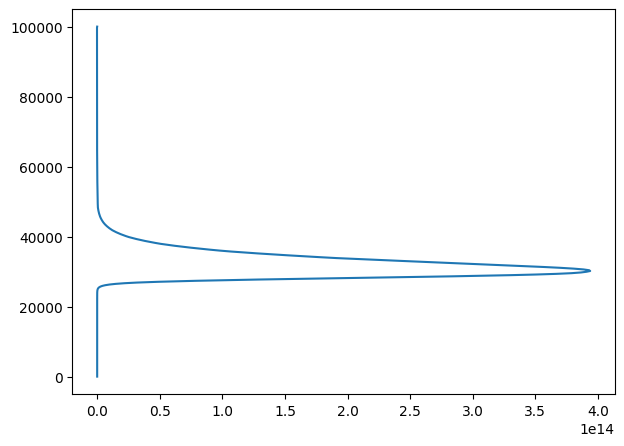

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(yy.dedz,yy.altitude)

In [12]:
chel = pd.read_csv('~/acs-armageddon-Dimorphos/resources/ChelyabinskEnergyAltitude.csv')

In [13]:
chel

,Height (km),Energy Per Unit Length (kt Km^-1)
0,42.1922,1.070700
1,39.9311,1.095450
2,39.0415,1.105190
3,38.4485,1.234830
4,38.0784,1.854650
...,...,...
123,22.3258,2.889170
124,22.1397,2.152290
125,21.9538,1.538560
126,21.7679,1.047980


In [ ]:
from scipy.interpolate import lagrange

[]

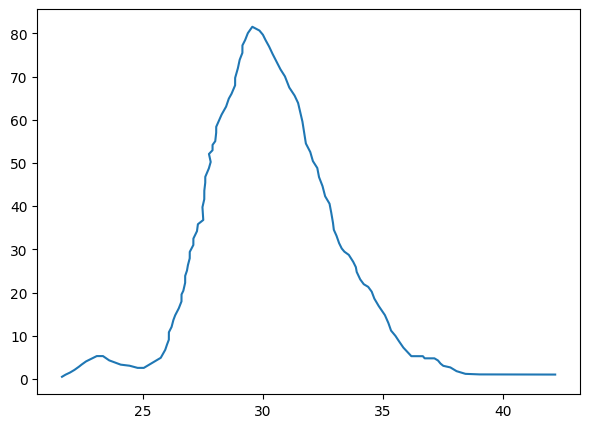

In [63]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(chel['Height (km)'],chel['Energy Per Unit Length (kt Km^-1)'],)
ax1.plot()


In [5]:
xdata = chel['Height (km)']
ydata = chel['Energy Per Unit Length (kt Km^-1)']

In [ ]:
xl = []
y = []
for i in range(20):

    

In [ ]:
x = [21.6192,22.3258,23.3290,25.0314,26.7576,29.3710,31.7921,34.3910,36.6733,38.0784,39.9311,40,42.1922]
y = [0.556991,2.889170,5.341250,2.61324,23.89990,80.0292,54.5100,21.35330,5.31833,1.85465,1.095450,1.07,1.070700]

In [ ]:
poly = lagrange(x, y)

In [ ]:
xdata = chel['Height (km)']
ydata = chel['Energy Per Unit Length (kt Km^-1)']

In [ ]:
from numpy.polynomial.polynomial import Polynomial
Polynomial(poly.coef[::-1]).coef

array([-2.64558295e+09,  1.06096276e+09, -1.93876614e+08,  2.13469518e+07,
       -1.57735988e+06,  8.24067556e+04, -3.12138302e+03,  8.63764023e+01,
       -1.73326395e+00,  2.45984883e-02, -2.34389506e-04,  1.34652588e-06,
       -3.52739439e-09])

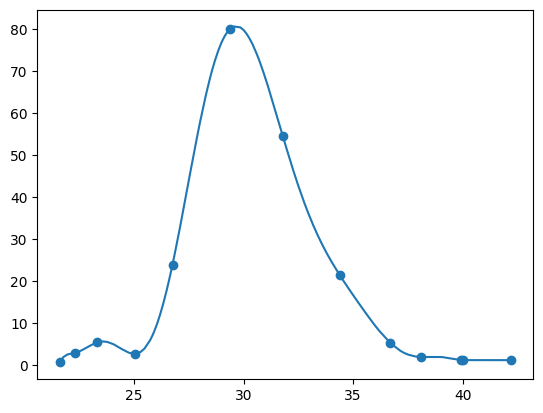

In [ ]:
x_new = xdata
plt.scatter(x, y, label='data')
plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Polynomial')

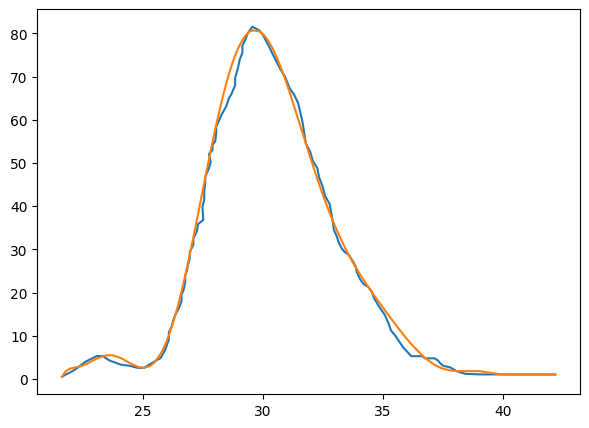

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(chel['Height (km)'],chel['Energy Per Unit Length (kt Km^-1)'],)
ax1.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Polynomial')

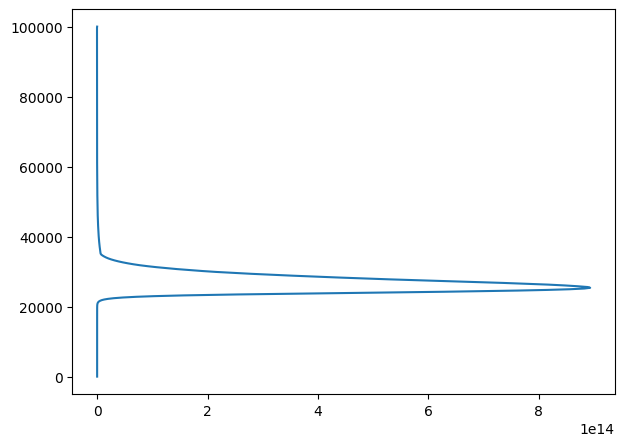

In [66]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(yy.dedz,yy.altitude)

In [67]:
test = yy[(yy.altitude>=21692.2)&(yy.altitude<=42192.2)][['altitude','dedz']]

In [68]:
test.altitude = test.altitude/1000

In [15]:
result = prep(yy)

In [16]:
result

,altitude,dedz
199,42.102936,2.604891
200,41.823220,2.896873
201,41.543681,3.242683
202,41.264328,3.621510
203,40.985171,4.032971
...,...,...
946,21.719525,0.000526
947,21.713525,0.000526
948,21.707525,0.000526
949,21.701527,0.000527


In [49]:
chel

,Height (km),Energy Per Unit Length (kt Km^-1)
0,42.1922,1.070700
1,39.9311,1.095450
2,39.0415,1.105190
3,38.4485,1.234830
4,38.0784,1.854650
...,...,...
123,22.3258,2.889170
124,22.1397,2.152290
125,21.9538,1.538560
126,21.7679,1.047980


In [26]:
x = [21.6192,22.3258,23.3290,25.0314,26.7576,29.3710,31.7921,34.3910,36.6733,38.0784,39.9311,40,42.1922]
y = [0.556991,2.889170,5.341250,2.61324,23.89990,80.0292,54.5100,21.35330,5.31833,1.85465,1.095450,1.07,1.070700]
poly = lagrange(x, y)
coefx = Polynomial(poly.coef[::-1])

In [27]:
coefx

Polynomial([-2.64558295e+09,  1.06096276e+09, -1.93876614e+08,  2.13469518e+07,
       -1.57735988e+06,  8.24067556e+04, -3.12138302e+03,  8.63764023e+01,
       -1.73326395e+00,  2.45984883e-02, -2.34389506e-04,  1.34652588e-06,
       -3.52739439e-09], domain=[-1,  1], window=[-1,  1])

In [68]:
chel

,Height (km),Energy Per Unit Length (kt Km^-1)
0,42.1922,1.070700
1,39.9311,1.095450
2,39.0415,1.105190
3,38.4485,1.234830
4,38.0784,1.854650
...,...,...
123,22.3258,2.889170
124,22.1397,2.152290
125,21.9538,1.538560
126,21.7679,1.047980


In [69]:
chelx = chel['Height (km)']
chely = chel['Energy Per Unit Length (kt Km^-1)']

In [54]:
len(chel)/5

25.6

In [52]:
128 /25

5.12

In [55]:
(len(chel)/5)

25.6

In [96]:
(len(chel)/(len(chel)/6))

6.0

125

In [97]:
xc = []
yc = []
for i in np.arange(1,21):
    xc.append(chelx[np.round(len(chel)/(len(chel)/6)) * i])
    yc.append(chely[np.round(len(chel)/(len(chel)/6)) * i])

In [98]:
xc

[37.5237,
 36.1914,
 35.2353,
 34.2063,
 33.3983,
 32.8512,
 32.0846,
 31.4678,
 30.4041,
 29.4457,
 28.9552,
 28.2773,
 27.7494,
 27.5536,
 27.0983,
 26.7561,
 26.2656,
 25.8503,
 24.4388,
 22.8465]

In [99]:
yc

[3.09226,
 5.3236,
 12.9696,
 21.971,
 29.4922,
 38.4884,
 50.4427,
 63.8732,
 75.2149,
 80.6442,
 71.9056,
 61.1987,
 52.0911,
 41.6253,
 31.039,
 22.2989,
 13.6835,
 6.05257,
 3.11234,
 4.73077]

In [100]:
poly = lagrange(xc, yc)

In [101]:
poly

poly1d([ 1.60777600e-07, -9.18136820e-05,  2.48110085e-02, -4.21728004e+00,
        5.05496592e+02, -4.53973300e+04,  3.16783465e+06, -1.75762959e+08,
        7.86867860e+09, -2.86746636e+11,  8.54097242e+12, -2.07935301e+14,
        4.12068649e+15, -6.58897402e+16,  8.37712205e+17, -8.27536311e+18,
        6.12490675e+19, -3.19670410e+20,  1.04941674e+21, -1.63019318e+21])

In [90]:
poly = lagrange(x, y)
coefx = Polynomial(poly.coef[::-1])

In [91]:
coefx

Polynomial([-2.64558295e+09,  1.06096276e+09, -1.93876614e+08,  2.13469518e+07,
       -1.57735988e+06,  8.24067556e+04, -3.12138302e+03,  8.63764023e+01,
       -1.73326395e+00,  2.45984883e-02, -2.34389506e-04,  1.34652588e-06,
       -3.52739439e-09], domain=[-1,  1], window=[-1,  1])

In [102]:
Polynomial(poly.coef[::-1])(chelx)

0      8.676962e+12
1     -4.461130e+12
2     -3.680196e+12
3     -2.822870e+12
4     -2.521199e+12
           ...     
123   -2.191000e+09
124   -8.488223e+08
125   -6.771180e+08
126   -3.810525e+09
127   -3.914334e+09
Name: Height (km), Length: 128, dtype: float64

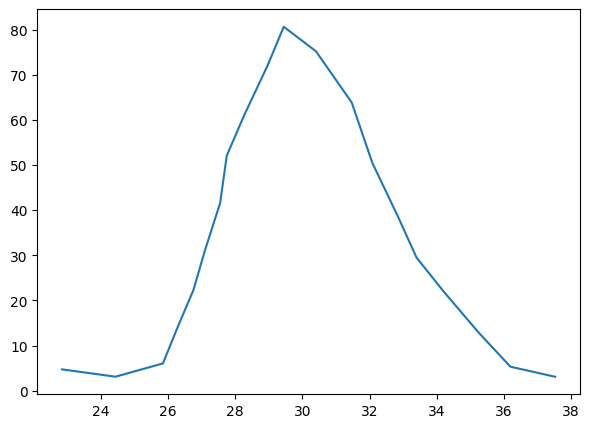

In [103]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(xc,yc)


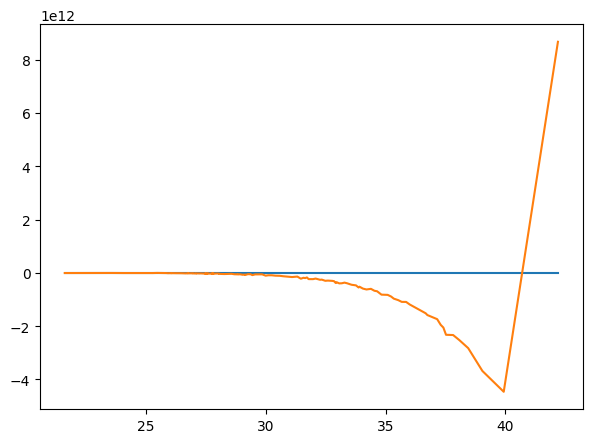

In [104]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(chel['Height (km)'],chel['Energy Per Unit Length (kt Km^-1)'])
ax1.plot(chelx, Polynomial(poly.coef[::-1])(chelx), label='Polynomial')

In [46]:
# from sklearn.metrics import mean_squared_error
# err1 = mean_squared_error(result.dedz,coefx(result.altitude),squared = False)

In [105]:
x = [21.6192,22.3258,23.3290,25.0314,26.7576,29.3710,31.7921,34.3910,36.6733,38.0784,39.9311,40,42.1922]
y = [0.556991,2.889170,5.341250,2.61324,23.89990,80.0292,54.5100,21.35330,5.31833,1.85465,1.095450,1.07,1.070700]
poly = lagrange(x, y)
coefx = Polynomial(poly.coef[::-1])

In [43]:
def rmse(result, coefx):
    actu_vals = np.array(result.dedz)
    pred_vals = np.array(coefx(result.altitude))

    difference = np.subtract(actu_vals, pred_vals)
    sqre_err = np.square(difference)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = np.sqrt(rslt_meansqre_err)
    
    return root_meansqre_err

In [69]:
test.dedz = test.dedz/(4.184*10**12)

In [70]:
test.max()

altitude     42.099719
dedz        213.423755
dtype: float64

In [71]:
chel

,Height (km),Energy Per Unit Length (kt Km^-1)
0,42.1922,1.070700
1,39.9311,1.095450
2,39.0415,1.105190
3,38.4485,1.234830
4,38.0784,1.854650
...,...,...
123,22.3258,2.889170
124,22.1397,2.152290
125,21.9538,1.538560
126,21.7679,1.047980


In [72]:
x1 = test.altitude
y1 = test.dedz

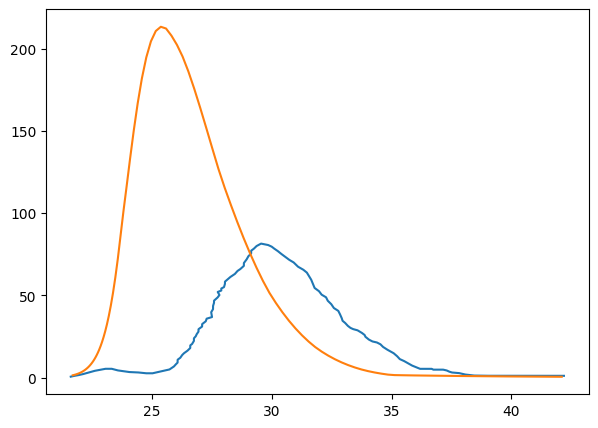

In [73]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(chel['Height (km)'],chel['Energy Per Unit Length (kt Km^-1)'],)
ax1.plot(x1,y1)

In [75]:
test.dedz.max()

213.42375537419275

In [14]:
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
def prep(result):
    test = result[(result.altitude>=21692.2)&(result.altitude<=42192.2)][['altitude','dedz']]
    test.altitude = test.altitude/1000
    test.dedz = test.dedz/(4.184*10**12)
    return test

x = [21.6192,22.3258,23.3290,25.0314,26.7576,29.3710,31.7921,34.3910,36.6733,38.0784,39.9311,40,42.1922]
y = [0.556991,2.889170,5.341250,2.61324,23.89990,80.0292,54.5100,21.35330,5.31833,1.85465,1.095450,1.07,1.070700]
poly = lagrange(x, y)
coefx = Polynomial(poly.coef[::-1])

In [187]:
radiuss = np.random.normal(9,1.75,10000)
strengths = np.random.normal(5e6,7e5,10000)

In [7]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

In [196]:
r = random.choice(radiuss)

11.00178563426904

In [202]:
test.dedz

199    0.488091
200    0.509198
201    0.535530
202    0.562286
203    0.589046
         ...   
317    1.644181
318    1.577284
319    1.514141
320    1.454484
321    1.398066
Name: dedz, Length: 123, dtype: float64

In [206]:
coefx(test.altitude)

199     5.759974
200    11.776346
201    11.102880
202     8.122370
203     5.059424
         ...    
317     1.803150
318     1.703634
319     1.596786
320     1.482506
321     1.360531
Name: altitude, Length: 123, dtype: float64

In [207]:
err = mean_squared_error(test.dedz,coefx(test.altitude),squared=False)

In [208]:
err

68.62440372893347

In [213]:
radiuss = np.random.normal(9,1.75,1000)
strengths = np.random.normal(5e6,7e5,1000)

In [214]:

i = 0
min = 68.62440372893347
min_para = []
while i < len(radiuss):
   r = random.choice(radiuss)
   s = random.choice(strengths)
   xx = Planet().solve_atmospheric_entry(radius = r, strength = s,velocity=19e3, density=3300, angle=18.3, init_altitude=100e3, dt=0.05, radians=False)
   yy = Planet().calculate_energy(xx)
   solver = prep(yy)
   err = mean_squared_error(true.dedz,coefx(true.altitude),squared=False)
   if err < min:  
      min = err
      min_para.append([r,s])
   print(i)
   i += 1    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [215]:
min_para

[[9.733344588676182, 5109378.307379512],
 [8.561045668437579, 4853335.084596278],
 [8.979033973292818, 3872428.698548669],
 [7.648141083184852, 4676177.702491996],
 [7.728359893334545, 4696441.698889146],
 [8.50641959427007, 4096264.4793621385],
 [7.791985665482935, 3694929.7067109435],
 [7.952184553351256, 3274007.4772488624],
 [8.013962884321705, 3917469.5477986205],
 [8.298536243852247, 3885938.047751798],
 [8.230031277855499, 3834330.442903589],
 [7.991949403357648, 3491750.572323372],
 [8.568362225333555, 3599090.3753851615],
 [8.540414482851272, 3413448.7769589014]]

In [2]:
result = Planet().solve_atmospheric_entry(radius=8.540414482851272,angle=18.3,strength=3413448.7769589014, density=3300,velocity=19.2e3)

In [3]:
result = Planet().calculate_energy(result)

In [4]:
result

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19200.000000,8.610719e+06,18.300000,100000.000000,0.000000,8.540414,0,-0.000000e+00
1,19200.153986,8.610719e+06,18.293319,99698.619172,897.405131,8.540414,0.05,-8.447115e+10
2,19200.307918,8.610719e+06,18.286638,99397.342216,1794.893848,8.540414,0.1,-8.447115e+10
3,19200.461796,8.610719e+06,18.279955,99096.169149,2692.466132,8.540414,0.15,-8.447115e+10
4,19200.615619,8.610719e+06,18.273272,98795.099990,3590.121967,8.540414,0.2,-8.447115e+10
...,...,...,...,...,...,...,...,...
9062,29.634638,1.349861e+06,89.942469,6.850062,242989.859252,88.727393,453.1,5.345069e+07
9063,29.632661,1.349861e+06,89.942469,5.368380,242989.860740,88.727393,453.15,5.343638e+07
9064,29.630684,1.349861e+06,89.942469,3.886797,242989.862228,88.727393,453.2,5.342208e+07
9065,29.628708,1.349861e+06,89.942469,2.405313,242989.863715,88.727393,453.25,5.340778e+07


In [8]:
true = prep(result)

In [15]:
x1 = true.altitude
y1 = true.dedz

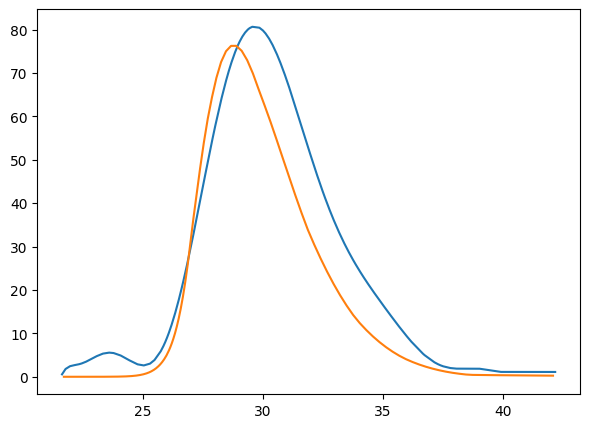

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
# coefx(chel['Height (km)'])
ax1.plot(chel['Height (km)'],chel['Energy Per Unit Length (kt Km^-1)'])
ax1.plot(x1,y1)